# Loading Packages 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import scipy.stats as stats 
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

import warnings
warnings.filterwarnings('ignore')

# Importing and Cleaning 

In [2]:
control_df = pd.read_csv('control_group.csv', sep = ';')
test_df = pd.read_csv('test_group.csv', sep = ';')

In [3]:
control_df.shape

(30, 10)

In [4]:
test_df.shape

(30, 10)

In [5]:
## Renaming the column

# for the control_df
for i in control_df.columns:
    if i.startswith('# of '):
        control_df = control_df.rename(columns = {i : i.replace('# of ', '')})
        
        
# for the test_df
        
for i in test_df.columns:
    if i.startswith('# of '):
        test_df = test_df.rename(columns = {i : i.replace('# of ', '')})
        
        

In [6]:
#Counting the null in the dataset 

control_df.isnull().sum()

Campaign Name     0
Date              0
Spend [USD]       0
Impressions       1
Reach             1
Website Clicks    1
Searches          1
View Content      1
Add to Cart       1
Purchase          1
dtype: int64

In [7]:
control_df[control_df.isnull().any(axis = 1)]



,Campaign Name,Date,Spend [USD],Impressions,Reach,Website Clicks,Searches,View Content,Add to Cart,Purchase
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
## since  we have most of the columns in the row  below as null, dropping row #4!

control_df.drop(4, inplace = True)

In [9]:
## checking the null in test_df

test_df.isnull().sum()

Campaign Name     0
Date              0
Spend [USD]       0
Impressions       0
Reach             0
Website Clicks    0
Searches          0
View Content      0
Add to Cart       0
Purchase          0
dtype: int64

In [10]:
## combining the control and the test set

df = pd.concat([control_df, test_df], axis = 0)

In [11]:
df.head()

,Campaign Name,Date,Spend [USD],Impressions,Reach,Website Clicks,Searches,View Content,Add to Cart,Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
5,Control Campaign,6.08.2019,3083,109076.0,87998.0,4028.0,1709.0,1249.0,784.0,764.0


In [12]:
df.dtypes

Campaign Name      object
Date               object
Spend [USD]         int64
Impressions       float64
Reach             float64
Website Clicks    float64
Searches          float64
View Content      float64
Add to Cart       float64
Purchase          float64
dtype: object

In [13]:
df.shape

(59, 10)

In [14]:
## updating the date column from object datatype to Datetime 

df['Date'] = pd.to_datetime(df['Date'], format = '%d.%m.%Y')

df['Date'].dt.year.value_counts()
df['Date'].dt.month.value_counts()

Date
8    59
Name: count, dtype: int64

In [15]:
## Using the day only in the date column since the year and the month are all the same 2019-08
df['Date'] = df['Date'].dt.day

In [16]:
## converting the float columns to the int 

df[df.select_dtypes(include = 'float').columns] = df[df.select_dtypes(include = 'float').columns].astype(int)


In [17]:
df.dtypes

Campaign Name     object
Date               int32
Spend [USD]        int64
Impressions        int64
Reach              int64
Website Clicks     int64
Searches           int64
View Content       int64
Add to Cart        int64
Purchase           int64
dtype: object

In [18]:
## outlier analysis 

def outlier_check(df, col):
    outlier_percent_col = {}
    for i in col:
        Q1 = df[i].quantile(0.25)
        Q3 = df[i].quantile(0.75)
        IQR = Q3- Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outlier = ((df[i]<lower_bound) | (df[i]>upper_bound)).sum()

        outlier_per = (outlier/ len(df[i]))* 100
        outlier_percent_col[i] = outlier_per

    return outlier_percent_col


In [19]:
col = (df.select_dtypes(include = 'number')).columns.tolist()
outlier_check(df, col)

{'Date': 0.0,
 'Spend [USD]': 0.0,
 'Impressions': 0.0,
 'Reach': 0.0,
 'Website Clicks': 0.0,
 'Searches': 1.694915254237288,
 'View Content': 1.694915254237288,
 'Add to Cart': 0.0,
 'Purchase': 0.0}

In [21]:
## Removing the outliers 

def outlier_remove(df, col):
    df_clean = df.copy()
    for i in col:
        Q1 = df_clean[i].quantile(0.25)
        Q3 = df_clean[i].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df_clean = df_clean[(df_clean[i] >= lower_bound) & (df_clean[i] <= upper_bound)]

    return df_clean


In [22]:
col = (df.select_dtypes(include = 'number')).columns.tolist()
final_df = outlier_remove(df, col)

In [23]:
final_df.shape

(58, 10)

In [24]:
## summary statistics 

final_df.describe()

,Date,Spend [USD],Impressions,Reach,Website Clicks,Searches,View Content,Add to Cart,Purchase
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,15.448276,2436.810345,91771.517241,70811.344828,5640.448276,2277.517241,1860.189655,1080.344828,525.241379
std,8.586347,379.559045,32748.596297,31291.458218,1739.721819,581.093381,620.208665,430.680268,197.100590
min,1.000000,1757.000000,22521.000000,10598.000000,2277.000000,1001.000000,848.000000,278.000000,222.000000
25%,8.250000,2095.750000,68148.750000,43224.500000,4224.250000,1954.250000,1249.000000,833.750000,346.500000
50%,15.500000,2439.500000,98281.000000,77422.000000,5581.000000,2374.500000,1934.500000,1067.000000,506.000000
75%,22.750000,2758.500000,117469.500000,95666.750000,7177.000000,2727.500000,2407.500000,1371.250000,701.000000
max,30.000000,3112.000000,145248.000000,127852.000000,8264.000000,3549.000000,3249.000000,1913.000000,890.000000


In [25]:
final_df.groupby('Campaign Name').describe()

Date                                                     \
                 count       mean       std  min   25%   50%    75%   max   
Campaign Name                                                               
Control Campaign  28.0  15.392857  8.508555  1.0  8.75  15.5  22.25  30.0   
Test Campaign     30.0  15.500000  8.803408  1.0  8.25  15.5  22.75  30.0   

                 Spend [USD]               ... Add to Cart         Purchase  \
                       count         mean  ...         75%     max    count   
Campaign Name                              ...                                
Control Campaign        28.0  2301.535714  ...      1654.5  1913.0     28.0   
Test Campaign           30.0  2563.066667  ...      1148.5  1391.0     30.0   

                                                                             
                        mean         std    min    25%    50%    75%    max  
Campaign Name                                                                
Control Campaign  529.535714  184.760201  222.0  382.5  506.0  686.0  800.0  
Test Campaign     521.233333  211.047745  238.0  298.0  500.0  701.0  890.0  

[2 rows x 72 columns]

# Visualization

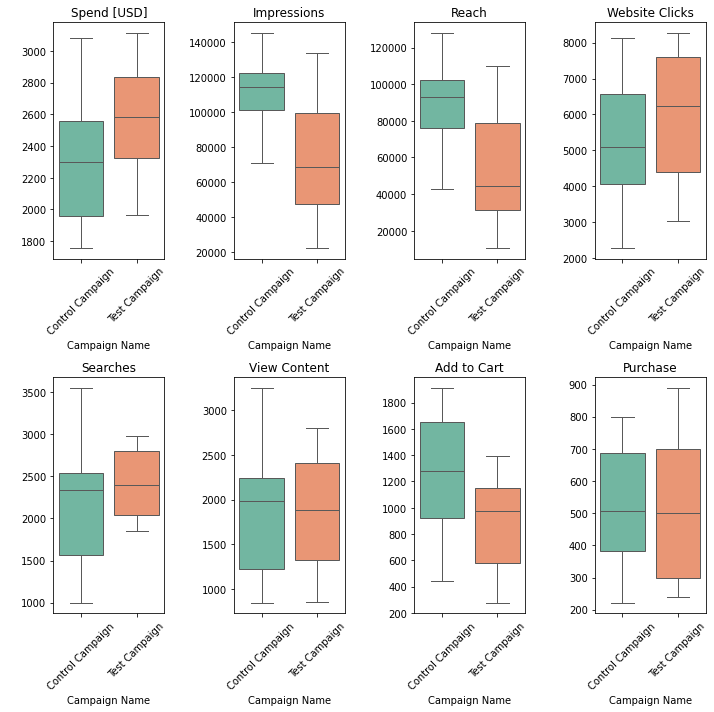

In [26]:
# Box plot for all the numeric columns 
num_cols = df.select_dtypes(include=["int"]).columns.to_list()
num_cols.remove("Date")


fig, axes = plt.subplots(2, 4, figsize = (10,10))
axes = axes.flatten()
for ix, i in enumerate(num_cols):
    sns.boxplot(data = final_df, x ='Campaign Name', y= i, ax = axes[ix], palette = 'Set2')
    axes[ix].tick_params(axis = 'x', rotation = 45)
    axes[ix].set_title(i)
    axes[ix].set_ylabel(' ')

plt.tight_layout()
plt.show()
    
        
    
    

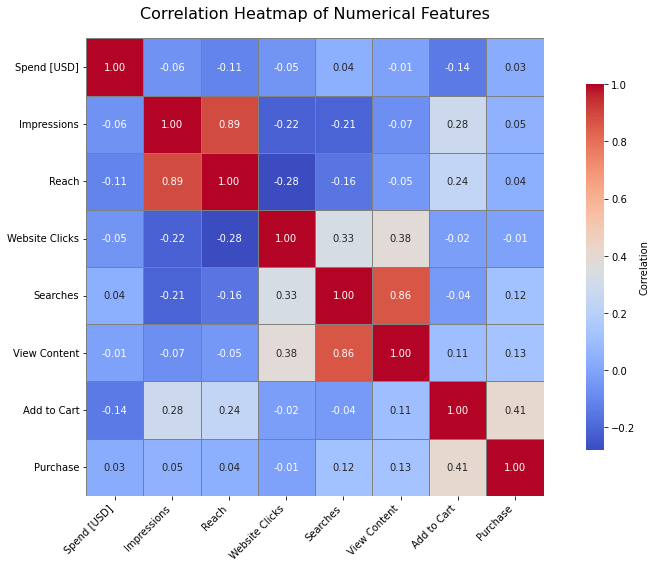

In [27]:
## creating a heatmap
plt.figure(figsize=(12, 8)) 
sns.heatmap(
    final_df[num_cols].corr(),
    annot=True,
    fmt=".2f",                 
    cmap='coolwarm',         
    linewidths=0.5,         
    linecolor='gray',        
    cbar_kws={'shrink': 0.8, 'label': 'Correlation'}, 
    square=True               
)
plt.title('Correlation Heatmap of Numerical Features', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)              
plt.tight_layout()
plt.show()

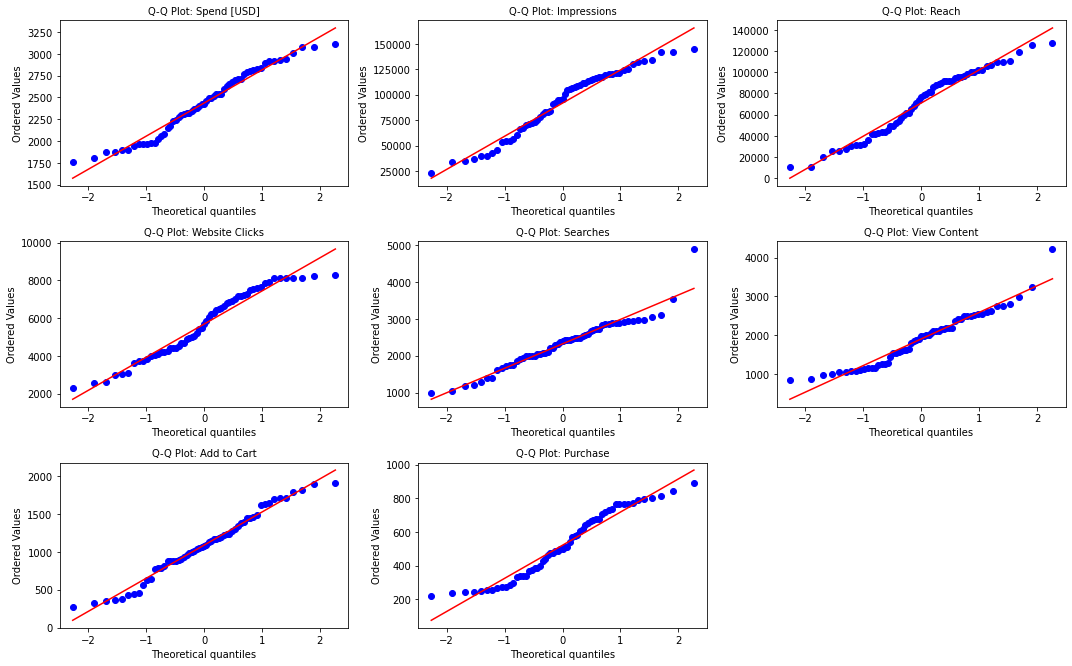

In [29]:
## Checking the normality assumption 

## QQ plot 

fig, axes = plt.subplots(4, 3, figsize=(15, 12)) 
axes = axes.flatten() 

for idx, col in enumerate(num_cols):
    stats.probplot(df[col], dist="norm", plot=axes[idx])
    axes[idx].set_title(f'Q-Q Plot: {col}', fontsize=10)

for i in range(len(num_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


# Metrics/Feature Engineering 

In [90]:
## 1.Conversion rate - How many people who visited the website ended up buying?

final_df['Conversion Rate'] = (final_df['Purchase']/final_df['Website Clicks']*100).round(2)

In [99]:
## 2. Click-Through Rate - the percentage of ad impressions that resulted in a user clicking the ad for more information.
final_df['Click through rate'] =(final_df['Website Clicks']/final_df['Impressions']*100).round(2)
                                 


In [100]:
#3. Cost per click - measures how much an advertiser pays each time a user clicks on their ad

final_df['Cost per click'] = (final_df['Spend [USD]']/final_df['Website Clicks']).round(2)
                                 


In [101]:
#4. Cost per conversion -  how much it costs to acquire one customer or completed action, such as a purchase or sign-up.

final_df['Cost per conversion'] =(final_df['Spend [USD]']/final_df['Purchase']).round(2)
                                 


In [103]:
final_df.head(5)

,Campaign Name,Date,Spend [USD],Impressions,Reach,Website Clicks,Searches,View Content,Add to Cart,Purchase,Conversion Rate,Click through rate,Cost per click,Cost per conversion
0,Control Campaign,1,2280,82702,56930,7016,2290,2159,1819,618,8.81,8.48,0.32,3.69
1,Control Campaign,2,1757,121040,102513,8110,2033,1841,1219,511,6.30,6.70,0.22,3.44
2,Control Campaign,3,2343,131711,110862,6508,1737,1549,1134,372,5.72,4.94,0.36,6.30
3,Control Campaign,4,1940,72878,61235,3065,1042,982,1183,340,11.09,4.21,0.63,5.71
5,Control Campaign,6,3083,109076,87998,4028,1709,1249,784,764,18.97,3.69,0.77,4.04


# Tests

### 1.
Test: Two-sample t-test (Welch’s)

Metric: Conversion Rate

Goal: See if test campaign converts more users than control

In [121]:
control = final_df.loc[final_df['Campaign Name'] == 'Control Campaign']
test = final_df.loc[final_df['Campaign Name'] == 'Test Campaign']

In [126]:
stats, p = ttest_ind(test['Conversion Rate'], control['Conversion Rate'], equal_var = False)

print(f'p-value: {p:.4f}')

p-value: 0.1060


We conducted an independent two-sample t-test to compare the conversion rates between the Control Campaign and Test Campaign.
The resulting p-value of 0.1060 indicates that there is no statistically significant difference at the 5% level.
Therefore, we fail to reject the null hypothesis, suggesting that the observed difference in conversion rates could be due to random chance.

### 2. 

Test: Two-sample t-test

Metric: Click through rate

Goal: Is the test campaign generating more interest/clicks?

In [140]:
t

p-value: 0.0002
Since the p-value is less than 0.05, we reject the null hypothesis.
There is a statistically significant difference in mean Click-Through Rate between the Test and Control campaigns.


### 3. 
Test: Mann-Whitney U test (non-parametric alternative to t-test)

Metric: Cost per conversion

Goal: Is the test campaign more cost-efficient?

In [139]:
stat, p = mannwhitneyu(test['Cost per conversion'], control['Cost per conversion'], alternative = 'two-sided')
print(f'Cost per Conversion p-value (Mann-Whitney): {p:.4f}')

# Interpretation
alpha = 0.05
if p < alpha:
    print(" The difference in Cost per Conversion between the groups is statistically significant.")
    print("We reject the null hypothesis: the distributions are different.")
else:
    print(" The difference is not statistically significant (p > 0.05).")
    print("We fail to reject the null hypothesis: no evidence of a meaningful cost efficiency difference.")

Cost per Conversion p-value (Mann-Whitney): 0.2308
 The difference is not statistically significant (p > 0.05).
We fail to reject the null hypothesis: no evidence of a meaningful cost efficiency difference.
